In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng, SeedSequence
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

sq = SeedSequence()
seed = sq.entropy
rng = default_rng(sq)

### Tools

In [2]:
def brownian_1d(n_times: int, n_paths: int, 
                final_time: float=1.0, 
                increments: bool=False, 
                random_state: np.random.Generator=rng) -> np.array:
    """Simulate paths of standard Brownian motion
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        increments: If `True` the increments of the paths are returned.
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths if the argument `increments` is `False`
        `np.array` of shape `(n_times, n_paths)` containing the increments if the argument `increments` is `True`
    """
    dB = np.sqrt(final_time / n_times) * random_state.standard_normal((n_times, n_paths))
    if increments:
        return dB
    else:
        brownian = np.zeros((n_times+1, n_paths))
        brownian[1:] = np.cumsum(dB, axis=0)
        return brownian

In [3]:
def black_scholes_1d(n_times: int, n_paths: int, 
                     final_time: float=1.0, 
                     random_state: np.random.Generator=rng, *,
                     init_value: float,
                     r: float, sigma: float) -> np.array:
    """Simulate paths of Black-Scholes process
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        init_value: `S0`
        r: Interest rate
        sigma: Volatility
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths 
    """
    Bt = brownian_1d(n_times, n_paths)
    times = np.arange(n_times+1)*(1/n_times)
    t = times[:, np.newaxis]
    St = init_value * np.exp((r - 0.5*sigma**2)*t + sigma*Bt)
    return St

In [4]:
# une fonction BS pour un payoff qui n'est pas path-dependent (offre plus de liberté pour le choix des gaussiennes dans la fonction)
def BS(x,r,sigma,T,N):
    """ args :
            x=spot
            r=interest rate
            sigma=volatility
            T=maturity
            N=simulated standard normal random variable
    """
    return  x*np.exp((r-(sigma**2)/2)*T+sigma*np.sqrt(T)*N)

# une fonction de payoff du call et sa dérivée par rapport à S_T
def payoff_call(S,r,T,K): return np.exp(-r*T)*np.maximum(S-K,0)
def payoff_put(S,r,T,K): return np.exp(-r*T)*np.maximum(K-S,0)

def call_derive(S,r,T,K): return np.exp(-r*T)*np.where(S>K,1,0)

In [5]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return (mean, var, mean - ci_size, mean + ci_size)

In [6]:
# Les formules fermées de Black-Scholes pour vérifier nos méthodes de MC

def d1(spot, t, r, sigma, strike):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r, sigma, strike):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def delta_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    return norm.cdf(d1_)

### Standard MC

In [7]:
# Fixons les paramètres

S0 = 100
T=1
K=100
r, sigma = 0.04, 0.20

In [8]:
Ms = 10**np.arange(3, 8)
results = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)
    results[M] = monte_carlo(payoffs)
results

,1000,10000,100000,1000000,10000000
Mean,9.712122,10.042327,9.886496,9.926891,9.926359
Var,189.080850,207.154298,206.833680,208.259954,207.870333
Lower,8.859863,9.760233,9.797359,9.898607,9.917422
Upper,10.564382,10.324422,9.975634,9.955176,9.935295


In [9]:
price_call_BS(S0, T, r, sigma, K)

9.925053717274437

# Antithetic variable method

Standard european option pricing. \
standard Call :
$$
X=(S_T - K)^+
$$
Synthetic Call with parity :
$$
X'=S_0-e^{-rT}K+e^{-rT}(K-S_T)^+
$$
Interpolated Call :
$$
\tilde{X}=\frac{X+X'}{2}
$$

In [35]:
S0 = 100
T=1
K=100
r, sigma = 0.04, 0.20

In [36]:
Ms = 10**np.arange(3, 8)
results = pd.DataFrame(index=['Crude Call', 'Var Crude', 'Synthetic Parity Call', 'Var Synthetic', 'Interpolated synthetic Call', 'Var interpolated'], columns=Ms)

for M in Ms:
    
    #on simule X
    gaussiennes = rng.standard_normal(M)
    X=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)
    
    #on simule X'
    gaussiennes = rng.standard_normal(M)
    Xprime=S0-K*np.exp(-r*T)+payoff_put(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)
    
    #on calcule X+X' /2
    gaussiennes = rng.standard_normal(M)
    Xtilde=(X+Xprime)/2
    
    results[M] = np.array((monte_carlo(X)[:2],monte_carlo(Xprime)[:2], monte_carlo(Xtilde)[:2])).flatten()

results

,1000,10000,100000,1000000,10000000
Crude Call,10.570629,10.210775,9.937660,9.931915,9.922200
Var Crude,225.856190,219.779614,208.017530,207.995431,207.884732
Synthetic Parity Call,9.693054,9.959306,9.911736,9.916269,9.923262
Var Synthetic,81.216591,80.668488,81.154639,80.861182,81.036891
Interpolated synthetic Call,10.131841,10.085041,9.924698,9.924092,9.922731
Var interpolated,79.335084,74.579698,72.237210,72.245182,72.254175


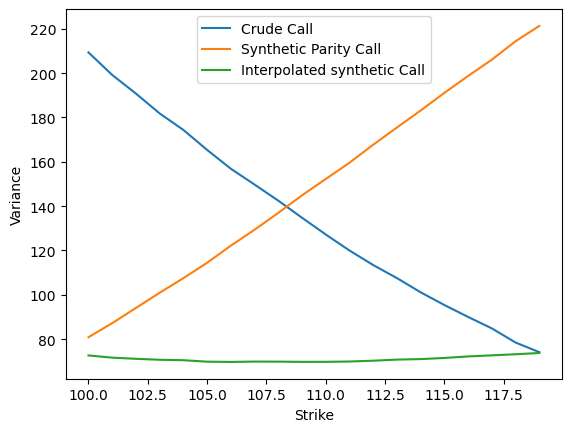

In [37]:
strikes=np.arange(100,120)
M=10**6
res=np.empty((3,1))

for K in strikes:
    gaussiennes = rng.standard_normal(M)
    X=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)

    #on simule X'
    gaussiennes = rng.standard_normal(M)
    Xprime=S0-K*np.exp(-r*T)+payoff_put(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)

    #on calcule X+X' /2
    gaussiennes = rng.standard_normal(M)
    Xtilde=(X+Xprime)/2

    # prime=price_call_BS(spot=S0, t=T, r=r, sigma=sigma, strike=K)
    res=np.c_[res,np.array([monte_carlo(X)[1], monte_carlo(Xprime)[1],monte_carlo(Xtilde)[1]])]
    
plt.plot(strikes, res[0,1:],label='Crude Call')
plt.plot(strikes, res[1,1:],label='Synthetic Parity Call')
plt.plot(strikes, res[2,1:],label='Interpolated synthetic Call')
plt.xlabel('Strike')
plt.ylabel('Variance')
plt.legend()
plt.show()